# Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
dataset= tf.keras.preprocessing.image_dataset_from_directory("PlantVillage",
                                                  shuffle=True,
                                                  image_size=(256,256),
                                                  batch_size=32)

Found 2152 files belonging to 3 classes.


In [3]:
classes=dataset.class_names

In [4]:
len(dataset) #here it is showing 68 coz there 32 batches of images so 68 images 

68

In [5]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    

(32, 256, 256, 3)
[1 1 0 0 1 1 0 1 0 0 1 0 1 0 1 1 0 0 1 0 1 2 0 0 1 0 1 1 1 1 1 0]


In [6]:
print(image_batch[0].numpy())

[[[191. 177. 174.]
  [198. 184. 181.]
  [206. 192. 189.]
  ...
  [156. 142. 142.]
  [159. 145. 145.]
  [167. 153. 153.]]

 [[193. 179. 176.]
  [198. 184. 181.]
  [205. 191. 188.]
  ...
  [150. 136. 136.]
  [152. 138. 138.]
  [159. 145. 145.]]

 [[195. 181. 178.]
  [199. 185. 182.]
  [204. 190. 187.]
  ...
  [150. 136. 136.]
  [152. 138. 138.]
  [157. 143. 143.]]

 ...

 [[159. 131. 128.]
  [149. 121. 118.]
  [158. 130. 127.]
  ...
  [152. 126. 127.]
  [141. 115. 116.]
  [144. 118. 119.]]

 [[142. 114. 111.]
  [151. 123. 120.]
  [166. 138. 135.]
  ...
  [156. 130. 131.]
  [145. 119. 120.]
  [148. 122. 123.]]

 [[142. 114. 111.]
  [151. 123. 120.]
  [151. 123. 120.]
  ...
  [150. 124. 125.]
  [142. 116. 117.]
  [148. 122. 123.]]]


## Image display

(-0.5, 255.5, 255.5, -0.5)

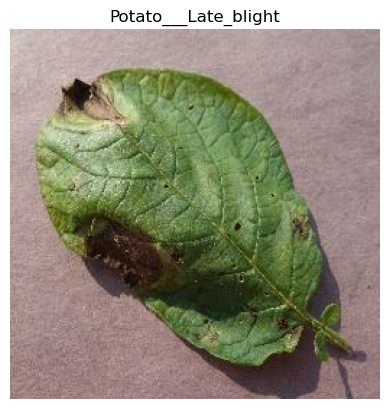

In [7]:
plt.imshow(image_batch[0].numpy().astype('uint8')) #here first if we define image_batch[0] it will give u first image in tensor and then putting numpy()converts into array then astype(uint8)so that plt.imshow can display the image
plt.title(classes[label_batch[0]])
plt.axis("off")

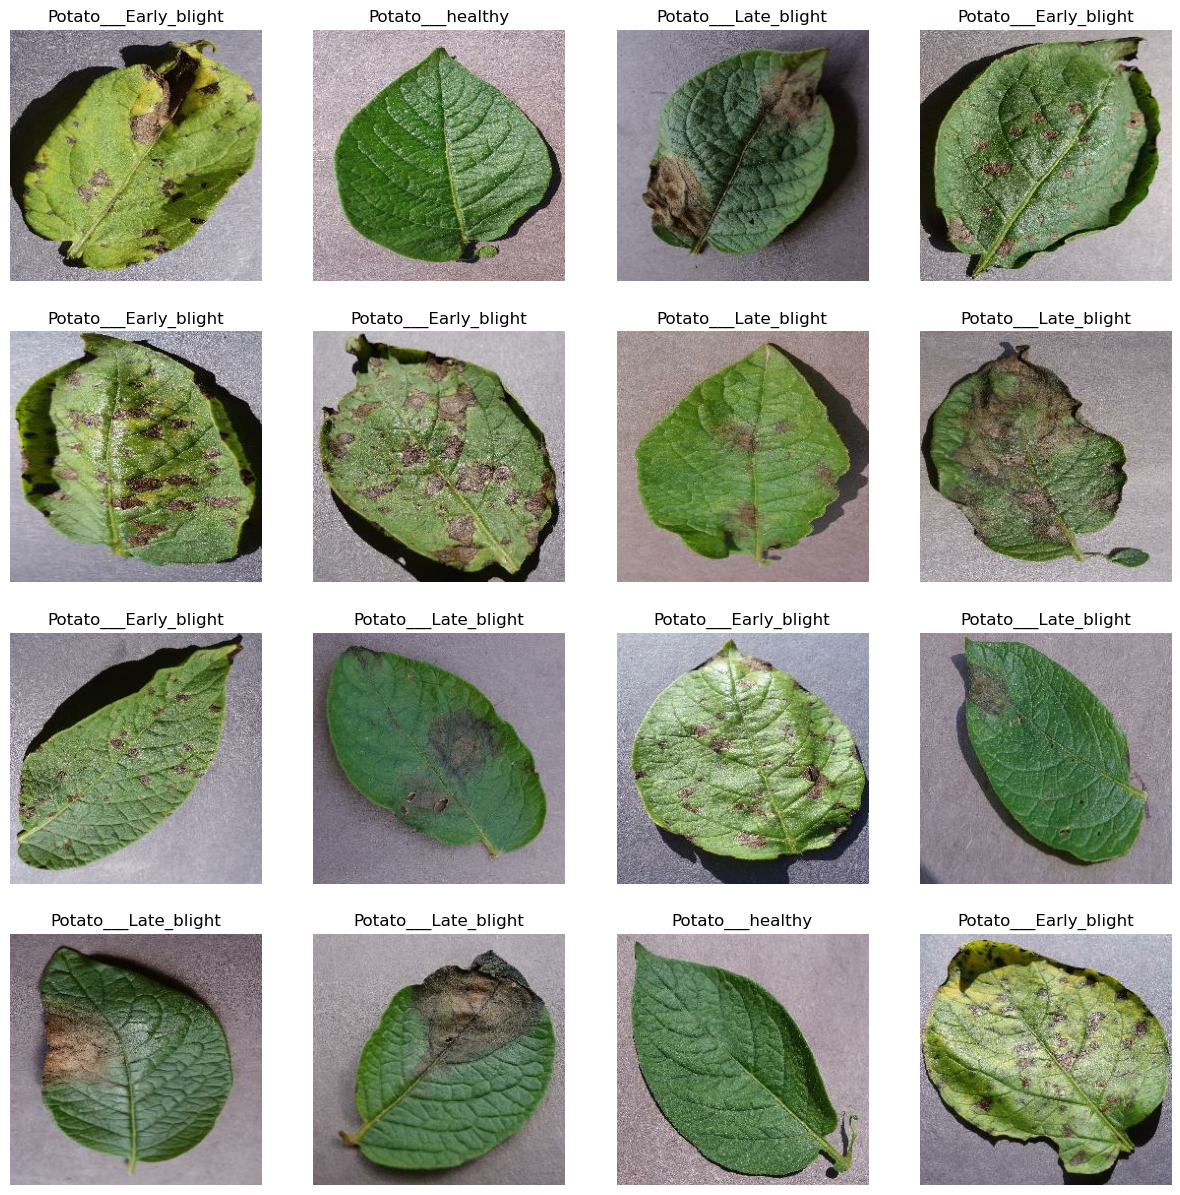

In [8]:
plt.figure(figsize=(15,15))
for image_batch,label_batch in dataset.take(1):
    
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(classes[label_batch[i]])
        plt.axis("off")

training and test data

In [9]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_data=dataset.take(54)
len(train_data)

54

In [11]:
test_data=dataset.skip(54)

In [12]:
len(test_data)

14

In [13]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [14]:
val_data=test_data.take(6)
len(val_data)

6

In [15]:
test_data=test_data.skip(6)
len(test_data)

8

## Caching and prefetch for better performance and fast training

In [16]:
td=train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
ted=test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
vd=val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#this code will read the image from the disk and then when we need the same image again for the next 
#iteration it wil keep that image in the memory this improves the performance

## scaling and resizing

In [17]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),#preprocessing pipeline
  layers.experimental.preprocessing.Rescaling(1.0/255),
]) #this will scale the image array between 0 and 1 which are between 0 to 255

## data augmentation

In [18]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [19]:
n_classes=3

model=models.Sequential([resize_and_rescale,data_augmentation,
                        layers.Conv2D(32,(3,3),activation='relu',
                                     input_shape=(256,256)),
                         layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=(32,256,256,3))#here the input shape is batch size image size,image size , rgb channels

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [22]:
 history=model.fit(
    train_data,
    batch_size=32,
    validation_data=val_data,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 94s 2s/step - loss: 0.9081 - accuracy: 0.4878 - val_loss: 0.9484 - val_accuracy: 0.4479
Epoch 2/50
54/54 [==============================] - 87s 2s/step - loss: 0.7805 - accuracy: 0.6030 - val_loss: 0.7178 - val_accuracy: 0.6667
Epoch 3/50
54/54 [==============================] - 86s 2s/step - loss: 0.4836 - accuracy: 0.8096 - val_loss: 0.4322 - val_accuracy: 0.8125
Epoch 4/50
54/54 [==============================] - 87s 2s/step - loss: 0.4489 - accuracy: 0.8102 - val_loss: 0.3469 - val_accuracy: 0.8542
Epoch 5/50
54/54 [==============================] - 107s 2s/step - loss: 0.2855 - accuracy: 0.8883 - val_loss: 0.2284 - val_accuracy: 0.9062
Epoch 6/50
54/54 [==============================] - 101s 2s/step - loss: 0.2565 - accuracy: 0.9034 - val_loss: 0.3155 - val_accuracy: 0.8594
Epoch 7/50
54/54 [==============================] - 117s 2s/step - loss: 0.1993 - accuracy: 0.9219 - val_loss: 0.3150 - val_accuracy: 0.8750
Epoch 8/50
54/54 

In [23]:
model.evaluate(test_data) #first is loss then is accuracy

8/8 [==============================] - 13s 1s/step - loss: 0.0471 - accuracy: 0.9784


[0.04705091938376427, 0.9784482717514038]

In [24]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
history.history['accuracy']

[0.4878472089767456,
 0.6030092835426331,
 0.8096064925193787,
 0.8101851940155029,
 0.8883101940155029,
 0.9033564925193787,
 0.921875,
 0.9288194179534912,
 0.9282407164573669,
 0.9490740895271301,
 0.9513888955116272,
 0.9594907164573669,
 0.9496527910232544,
 0.9658564925193787,
 0.9756944179534912,
 0.9346064925193787,
 0.9629629850387573,
 0.9809027910232544,
 0.9635416865348816,
 0.9791666865348816,
 0.9832175970077515,
 0.9849537014961243,
 0.9866898059844971,
 0.9751157164573669,
 0.9832175970077515,
 0.9820601940155029,
 0.9849537014961243,
 0.9866898059844971,
 0.9826388955116272,
 0.9704861044883728,
 0.9866898059844971,
 0.9878472089767456,
 0.9901620149612427,
 0.9907407164573669,
 0.9849537014961243,
 0.9942129850387573,
 0.9826388955116272,
 0.9861111044883728,
 0.9849537014961243,
 0.9861111044883728,
 0.9866898059844971,
 0.9884259104728699,
 0.9930555820465088,
 0.9832175970077515,
 0.9918981194496155,
 0.9907407164573669,
 0.9924768805503845,
 0.9924768805503845,
 0

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

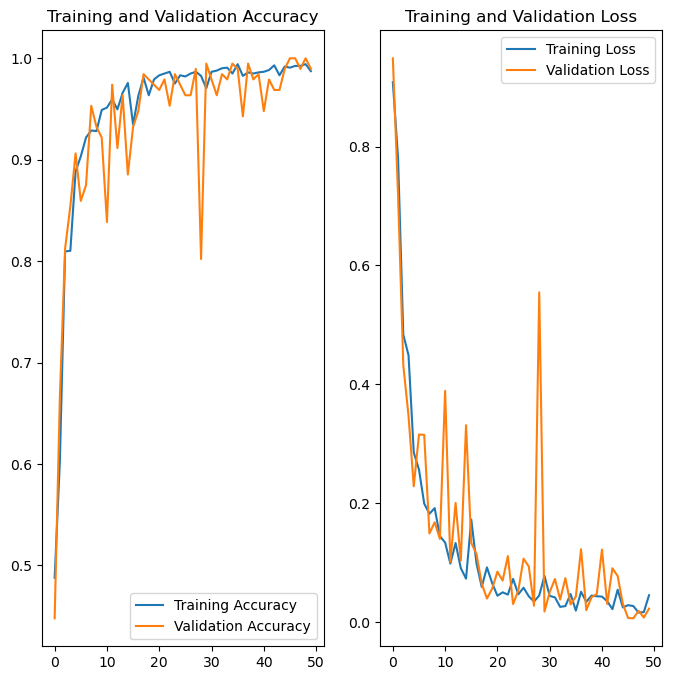

In [30]:
EPOCHS=50

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [34]:
import numpy as np
batch_pred=model.predict(image_batch)
print('predicted label:',classes[np.argmax(batch_pred[0])])#as prediction will give give 3 probabbilities so the one having max no. is the class so get the max we use np.argmax to get the index of the max number wala class and then putting index as classes will tell the class name

1/1 [==============================] - 1s 1s/step
predicted label: Potato___Early_blight


In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 65ms/step


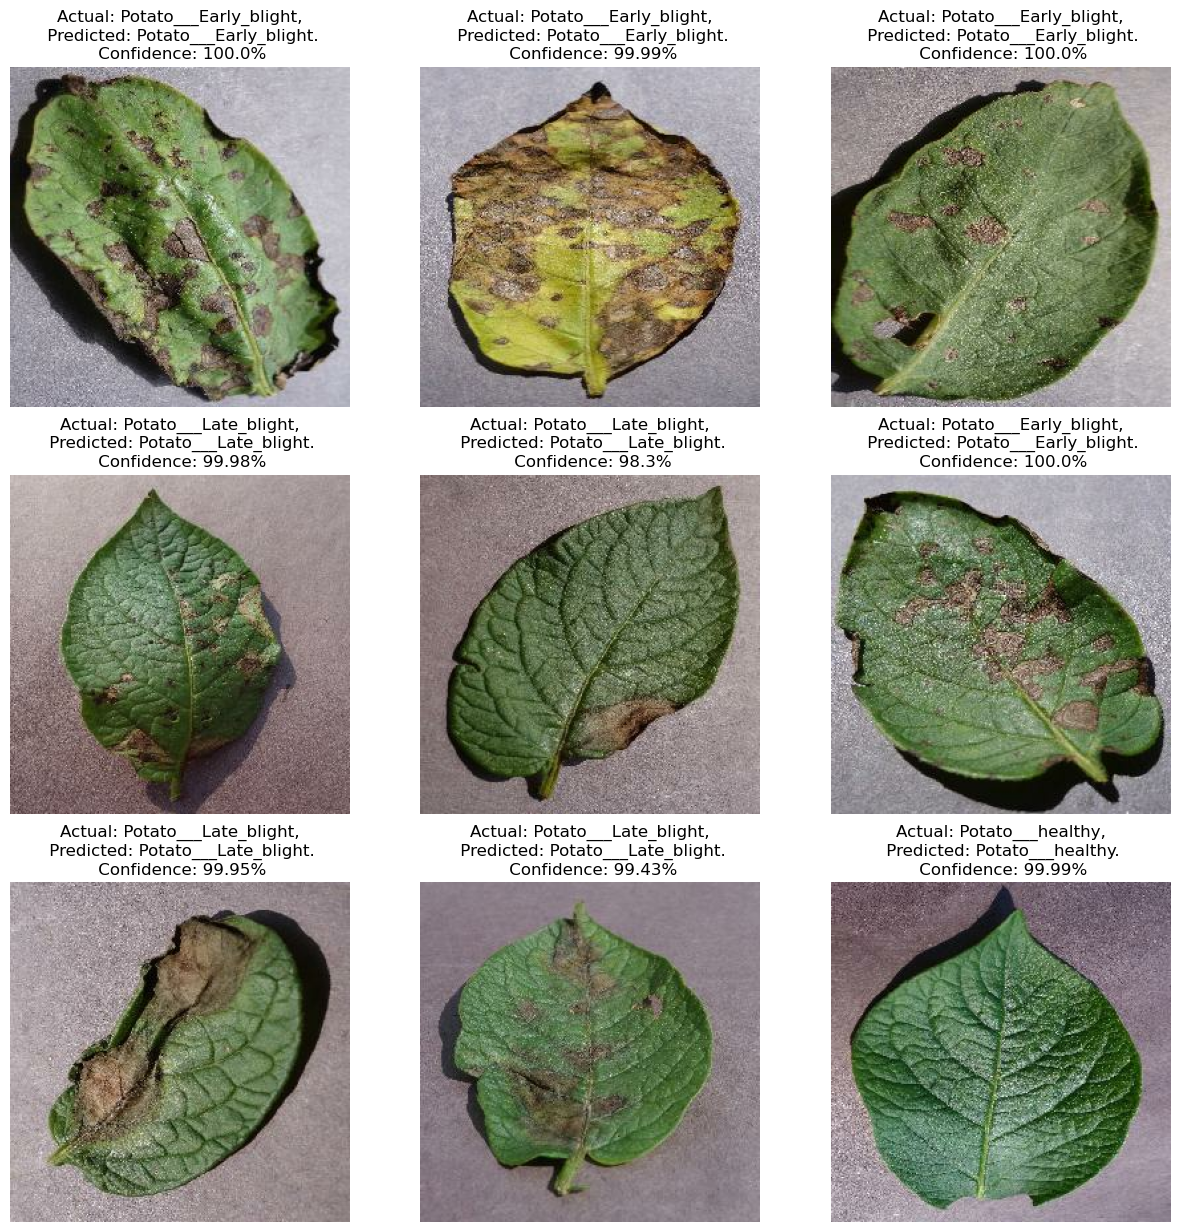

In [45]:
## running on few samples
plt.figure(figsize=(15, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")